# Shapley values

Está basado en la teoria de juegos. Tenemos a varios jugadores jugando en equipo, queremos saber cuanto influye cada uno de los jugadores en el resultado del juego. 
Para ver la contribución de cada jugador en el resultado se calcula:

- Todas las combinaciones posibles de jugadores que incluyan a ese jugador. 
    - Para cada combinación (x') se calcula:
        - El resultado obtenido en el juego con esa combinación ($Y_{con}$)
        - El resultado obtenido en el juego con esa combinación, al excluir al jugador a estudiar ($Y_{sin}$)
        - Valor marginal = $Y_{con} - Y_{sin}$

El shap value de ese jugador es la media de todos los valores marginales calculados.

Se calculan todas las posibles combinaciones porque el jugador A puede jugar mejor si está con B, por lo tango hay que hacer una media de su aportación para saber lo que aporta independientemente de con quien esté jugando

En este ejemplo los jugadores serían variables, el juego sería el modelo y el resultado sería el output del modelo.

### e.g. Shapley de A

El equipo lo forman los jugadores A, B y C. Queremos estudiar cuanto aporta A al equipo

Combinaciones posibles con sus resultados

- A,B,C -> $Y_{ABC}$
- A,B -> $Y_{AB}$
- A,C -> $Y_{AC}$
- A -> $Y_{A}$

Valores marginales

- $marginal_{ABC} = Y_{ABC} - Y_{BC}$
- $marginal_{AB} = Y_{AB} - Y_{B}$
- $marginal_{AC} = Y_{AC} - Y_{C}$
- $marginal_{A} = Y_{A} - Y$

$$\phi_A(modelo, row) = \frac {marginal_{ABC}+marginal_{AB}+marginal_{AC}+marginal_{A}}4$$

<div style="text-align: center"> El shapley value para A, para ese juego (modelo), para esa row (muestra) será la media de los valores marginales</div>

<div style="text-align: center">  Realmente no es una media exacta es ponderada, la formula se ve a continuación </div>

## Formula

$$\phi_{i}(f,x) = \sum_{z' ⊆ x'} \frac{\lvert z'\lvert !  (M- \lvert z' \lvert -1)!}{M!} [f_{x}(z') - f_{x}(z'/i)]$$

- $\phi_{i}$: shapley value of i para el modelo f en la muestra x
- f: model
- x: data input (row), (e.g. Age = 56, Gender = F, BMI = 30, HR = 80)
- z': subset
- x': simplified data input (row), (e.g. Age = 56, Gender = NA, BMI = NA, HR = 80)
- M: n features incluidas
- $f_{x}(z')$: resultados con todo z'
- $f_{x}(z'/i)$: resultados con todo z' menos la feature a estudiar
- Contribución de la variable (valor marginal): $[f_{x}(z') - f_{x}(z'/i)]$
- Peso de la contribución: $\frac{\lvert z'\lvert !  (M- \lvert z' \lvert -1)!}{M!}$

Para calcular el shapley value de i se calculan todos los x' posibles (subset of a set = $2^n$), se calcula el *valor marginal* para cada x' y se ponderan todos los valores marginales segun *peso de la contribución*

Si  $f_{x}(Age = 56, HR = 80) = 0.7$  y $f_{x}(HR = 80) = 0.1$, entonces Age contribuye un 0.6

 # SHAP kernel

In [53]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

## Modelo de regresión logística

Vamos a construir un modelo que predice el riesgo de ictus en funcion de cuatro variables

In [54]:
df = {'Age': [56, 72, 56, 40, 25, 60, 38], 
      'Gender_F': [1, 0, 0, 1, 1, 0, 1], 
      'BMI': [30, 40, 25, 20, 26, 20, 27], 
      'HR': [80, 150, 100, 70, 60, 75, 82],
      'Stroke': [1, 1, 1, 0, 0, 0, 0]}
df = pd.DataFrame(df)
df

,Age,Gender_F,BMI,HR,Stroke
0,56,1,30,80,1
1,72,0,40,150,1
2,56,0,25,100,1
3,40,1,20,70,0
4,25,1,26,60,0
5,60,0,20,75,0
6,38,1,27,82,0


In [55]:
reg = RandomForestClassifier()
model = reg.fit(df.iloc[:,0:4], df['Stroke'])

Nos quedamos con la probabilidad

In [62]:
df['prediction'] = model.predict_proba(df.iloc[:,0:4])[:,1]
df

,Age,Gender_F,BMI,HR,Stroke,prediction
0,56,1,30,80,1,0.63
1,72,0,40,150,1,0.98
2,56,0,25,100,1,0.65
3,40,1,20,70,0,0.02
4,25,1,26,60,0,0.06
5,60,0,20,75,0,0.19
6,38,1,27,82,0,0.13


**Una vez construido un modelo**, se quiere calcular el SHAP value de cada variable en cada fila.

## SHAP value muestra 1

Cada muestra tiene un data input concreto, en este caso:
    
- $x_1$ = [Age = 56, Gender = F, BMI = 30, HR = 80] con un output Y = 0.74

Para esta fila existen muchos x' (combinaciones posibles de variables). 
    
- $x'_1$ = [Age = 56, Gender = NA, BMI = NA, HR = 80]
- $x'_1$ = [Age = 56, Gender = F, BMI = NA, HR = NA]
- $x'_1$ = [Age = NA, Gender = NA, BMI = 30, HR = 80]
- $x'_1$ = [Age = 56, Gender = F, BMI = 30, HR = NA]
- $x'_1$ = [Age = NA, Gender = NA, BMI = NA, HR = 80]
- $x'_1$ = [Age = NA, Gender = F, BMI = 30, HR = NA]

Podriamos intentar hacer todas las combinaciones posibles de variables, pero esto supondría mucho coste computacional, habría que calcular $2^n*n$ combinaciones. Por eso lo que se hace es solo calcular algunas.

In [147]:
df_x1 = {'Age': [56, 56, 56, float('nan'), 56, float('nan'), float('nan')], 
         'Gender_F': [1, float('nan'), 1, float('nan'), 1, float('nan'), 1], 
         'BMI': [30, float('nan'), float('nan'), 30, 30, float('nan'), 30], 
         'HR': [80, 80, float('nan'), 80, float('nan'), 80, float('nan')]}
df_x1 = pd.DataFrame(df_x1)
df_x1

,Age,Gender_F,BMI,HR
0,56.0,1.0,30.0,80.0
1,56.0,NaN,NaN,80.0
2,56.0,1.0,NaN,NaN
3,NaN,NaN,30.0,80.0
4,56.0,1.0,30.0,NaN
5,NaN,NaN,NaN,80.0
6,NaN,1.0,30.0,NaN


Para cada una de estas x' se puede calcular un output

*Realmente en muchos modelos no se puede introducir NA y* ***lo que se hace es introducir un valor que se escoge aleatoriamente del train dataset***

In [176]:
df_x1 = {'Age': [56, 56, 56, 25, 56, 38, 40], 
         'Gender_F': [1, 1, 1, 0, 1, 1, 1], 
         'BMI': [30, 26, 20, 30, 30, 27, 30], 
         'HR': [80, 80, 60, 80, 75, 80, 100]}
df_x1 = pd.DataFrame(df_x1)
df_x1['prediction'] = model.predict_proba(df_x1.iloc[:,0:4])[:,1]
df_x1

,Age,Gender_F,BMI,HR,prediction
0,56,1,30,80,0.63
1,56,1,26,80,0.41
2,56,1,20,60,0.16
3,25,0,30,80,0.46
4,56,1,30,75,0.45
5,38,1,27,80,0.15
6,40,1,30,100,0.50


Una vez se ha calculado el output de cada combinación se construye un nuevo dataset con el que se calculará una regresión lineal, de la que se extraeran los SHAP values

$$ Y = x_{1} \beta_{1} + x_{2} \beta_{2} + x_{3} \beta_{3} +...+x_{i} \beta_{i}$$

- x: si la varaible está o no presente
- $\beta$: shapley value
- Y: predicción del modelo

In [177]:
df_shap = {'Age': [1,1,1,0,1,0,0], 
           'Gender_F': [1,0,1,0,1,0,1], 
           'BMI': [1,0,0,1,1,0,1], 
           'HR': [1,1,0,1,0,1,0], 
           'prediction': model.predict_proba(df_x1.iloc[:,0:4])[:,1]}
df_shap = pd.DataFrame(df_shap)

In [178]:
df_shap

,Age,Gender_F,BMI,HR,prediction
0,1,1,1,1,0.63
1,1,0,0,1,0.41
2,1,1,0,0,0.16
3,0,0,1,1,0.46
4,1,1,1,0,0.45
5,0,0,0,1,0.15
6,0,1,1,0,0.50


Se ve que este nuevo dataset lo que tiene es un valor 0, 1 para cada variable, en función de si esa variable está presente, y un output con cada cálculo. Cada fila de df_shap es una combinación de variables (jugadores), y su output (resultado en el juego).

Vemos que en este caso no es como en la primera explicación, que se hacía un cálculo por cada una de las variables, en cada una de las muestras. Aqui por cada muestra (row) se calculan todos los shapley values ($\beta$) mediante una regresión lineal.

In [179]:
reg = LinearRegression()

In [180]:
shap_model = reg.fit(df_shap.iloc[:,0:4], df_shap['prediction'])

In [181]:
resultados = {'variables': list(df.columns[0:4]), 'shap': list(shap_model.coef_)}
pd.DataFrame(resultados)

,variables,shap
0,Age,0.105
1,Gender_F,0.020
2,BMI,0.300
3,HR,0.125


Aqui vemos el SHAP value de cada variable para la muestra 1. Vemos que la edad ha aumentado la probabilidad de ictus, el sexo femenino también la ha aumentado, el BMI la ha aumentado y la HR la ha disminuico

## Calculo con el paquete

In [182]:
import shap

In [183]:
X3 = shap.utils.sample(df_shap.iloc[:,0:4], 3) # 3 instances for use as the background distribution

La background distribution es la que se usa para rellenar los valores faltantes, son datos del train dataset que se guardan para rellenar los NA

In [193]:
explainer = shap.Explainer(model.predict_proba, X3)
shap_values = explainer(df.iloc[:,0:4])

He tomado para la explicación la probabilidad, no el resultado 0,1, asi tenemos más información

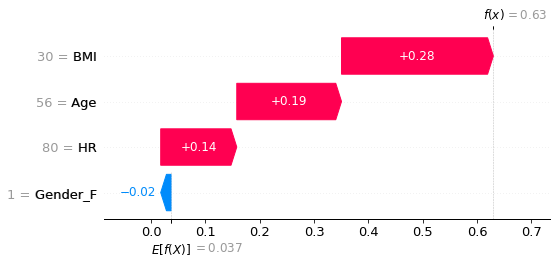

In [185]:
shap.plots.waterfall(shap_values[0,:,1], max_display=20)

Vemos que aqui los resultados nos salen diferentes, pero es normal, porque hemos generado pocas muestras aleatorias en el modelo, probablemente el paquete haya calculado más, y además las haya rellenado con otros valores. 

Los valores con los que rellenamso los NA, influyen en los resultados. Por eso es mejor hacerlo con muestras grandes, ya que con muestras grandes al rellenar un valor varias veces de manera aleatoria la tendencia es a que no tenga ningun peso, pero en nuestro caso que lo hemos rellenado solo 3 veces, las muestras aleatorias escogidas, van a influir en los resultados

In [111]:
shap_values.values

array([[[-1.95000000e-01,  1.95000000e-01],
        [ 0.00000000e+00,  0.00000000e+00],
        [-2.75000000e-01,  2.75000000e-01],
        [-1.40000000e-01,  1.40000000e-01]],

       [[-2.15000000e-01,  2.15000000e-01],
        [-5.00000000e-02,  5.00000000e-02],
        [-3.40000000e-01,  3.40000000e-01],
        [-3.55000000e-01,  3.55000000e-01]],

       [[-1.76666667e-01,  1.76666667e-01],
        [-5.66666667e-02,  5.66666667e-02],
        [-8.16666667e-02,  8.16666667e-02],
        [-3.15000000e-01,  3.15000000e-01]],

       [[ 0.00000000e+00,  2.60208521e-18],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  8.67361738e-19],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 5.55111512e-17,  8.67361738e-19],
        [ 0.00000000e+00,  0.00000000e+00],
        [-4.00000000e-02,  4.00000000e-02],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[-1.30000000e-01,  1.30000000e-01],
        [-4.00000000e-02,  4.00000000e-02],
        [ 0.00000000e+

Aqui estan los resultados probabilisticos para 0 y para 1, nosotros nos interesa 1, por lo que nos quedaremos con [:,:,1]

In [112]:
pd.DataFrame(shap_values.values[:,:,1], columns = df.iloc[:,0:4].columns)

,Age,Gender_F,BMI,HR
0,1.950000e-01,0.000000,2.750000e-01,0.140
1,2.150000e-01,0.050000,3.400000e-01,0.355
2,1.766667e-01,0.056667,8.166667e-02,0.315
3,2.602085e-18,0.000000,8.673617e-19,0.000
4,8.673617e-19,0.000000,4.000000e-02,0.000
5,1.300000e-01,0.040000,6.938894e-18,0.000
6,1.734723e-18,0.000000,3.000000e-02,0.080


Aqui vemos el SHAP value de cada variable para cada muestra

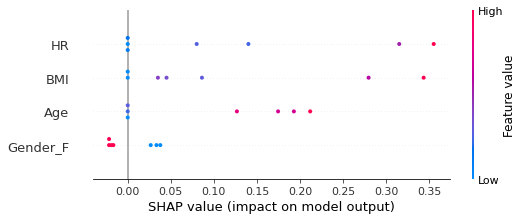

In [188]:
shap.plots.beeswarm(shap_values[:,:,1])

Vemos que todas las variables tienen practicamente efecto positivo. Eso es lógico ya que los resultados de probabilidad van de 0 a 1, por lo tango es extraño qeu alguna variable reste. 

- **HR**: vemos que los valores más altos (más rojos) están mas a la derecha, por lo que aumentan la probabilidad de ictus
- **BMI**: Vemos que sucede lo mismo que con HR
- **Age**: Lo mismo que en las anteriores
- **Gender_F**: Aqui vemos que los valores elevados (ser mujer) restan, y los valores bajos (ser hombre) suman. Es decir, los hombres tienen más riesgo que las mujeres.

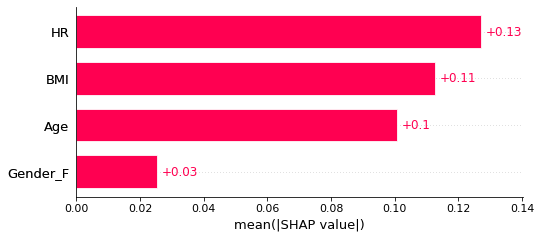

In [190]:
shap.plots.bar(shap_values[:,:,1])

Aqui se ve el peso medio de cada una de las variables, se ve que la mas importante es HR.

In [204]:
explainer = shap.Explainer(model.predict, X3)
shap_values = explainer(df.iloc[:,0:4])

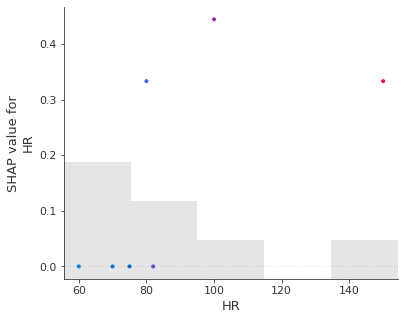

In [206]:
shap.plots.scatter(shap_values[:,"HR"], color=shap_values)